# Setup

In [0]:
import os
import cv2
import requests
import ftplib

try:
  import sentinelsat
except:
  !pip install sentinelsat
  import sentinelsat

try:
  import netCDF4 as nc
except:
  !pip install netCDF4
  import netCDF4 as nc

try:
  from mpl_toolkits.basemap import Basemap
except:
  !apt-get install libgeos-3.5.0
  !apt-get install libgeos-dev
  !pip install https://github.com/matplotlib/basemap/archive/master.zip
  !pip install pyproj==1.9.6
  from mpl_toolkits.basemap import Basemap

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import geopy.distance as geoDist

from keras.models import Model, load_model
import keras.backend as K

from IPython.display import clear_output

# Mount my google drive
clear_output()
from google.colab import drive
print("Make sure you have restarted the instance after installing the new packages.\n\nMount Google Drive Now")
drive.mount('/content/gdrive')

clear_output()

# CMEMS Authentication Details
# Enter your credentials here
# cmems_username = ""
# cmems_password = ""

# Set up the sentinel API
# Enter your credentials here
# odata_username = ""
# odata_password = ""
search_api = sentinelsat.SentinelAPI(odata_username, odata_password)

# Root access path
service_root_URI = "https://scihub.copernicus.eu/apihub/odata/v1/"

# Dimension of all input images and labels (assume nxn)
image_dimension = 128

# Dataset location
dataset_location_path   = "/content/gdrive/Shared drives/ICE_CHARTING_UCT_WSA/Data"

# Models folder location
model_location_path = "/content/gdrive/Shared drives/ICE_CHARTING_UCT_WSA/Models"

# Show all available models for the user to choose
os.chdir(model_location_path)
print("The following models are available:")
for model_name in os.listdir():
  if os.path.isdir(model_name):
    # Only print out folder names for the user to choose from
    print("\t" + model_name)
print("Please choose which models to use, and enter their names in the following cell.")

# Loss & Metrics (Make sure this section is updated if any changes are made in the Model Implementation notebook)
# Uncertainty weighted versions of MAE & MSE
def uncertainty_weighted_MAE(y_true, y_pred):
  # y_true contains the concentration label, and the uncertainty as two two channels
  y_target    = y_true[:, :, :, :1]
  uncertainty = y_true[:, :, :, 1:]
  # Calculate the weighted MAE
  loss = K.abs(y_pred - y_target)
  loss = loss * (K.ones_like(loss) - uncertainty) # Scale the error by the 'certainty' of the label
  return K.mean(loss, axis=-1)

def uncertainty_weighted_MSE(y_true, y_pred):
  # y_true contains the concentration label, and the uncertainty as two two channels
  y_target    = y_true[:, :, :, :1]
  uncertainty = y_true[:, :, :, 1:]
  # Calculate the weighted MSE
  loss = K.abs(y_pred - y_target)
  loss = loss * (K.ones_like(loss) - uncertainty) # Scale the error by the 'certainty' of the label
  return K.mean(K.square(loss), axis=-1)

# Uncertainty biased versions of MAE & MSE
def uncertainty_biased_MAE(y_true, y_pred):
  # y_true contains the concentration label, and the uncertainty as two two channels
  y_target    = y_true[:, :, :, :1]
  uncertainty = y_true[:, :, :, 1:]
  # Calculate the biased MAE
  loss = K.abs(y_pred - y_target)
  loss = K.maximum(K.zeros_like(loss), (loss - uncertainty))
  return K.mean(loss, axis=-1)

def uncertainty_biased_MSE(y_true, y_pred):
  # y_true contains the concentration label, and the uncertainty as two two channels
  y_target    = y_true[:, :, :, :1]
  uncertainty = y_true[:, :, :, 1:]
  # Calculate the biased MSE
  loss = K.abs(y_pred - y_target)
  loss = K.maximum(K.zeros_like(loss), (loss - uncertainty))
  return K.mean(K.square(loss), axis=-1)

# Standard Mean Absolute Error & Mean Squared Error
def myMAE(y_true, y_pred):
  # y_true contains the concentration label, and the uncertainty as two two channels
  y_target = y_true[:, :, :, :1]
  # Calculate the MSE
  return K.mean(K.abs(y_pred - y_target), axis=-1)

def myMSE(y_true, y_pred):
  # y_true contains the concentration label, and the uncertainty as two two channels
  y_target = y_true[:, :, :, :1]
  # Calculate the MSE
  return K.mean(K.square(y_pred - y_target), axis=-1)

loss_dictionary =  {"uncertainty_weighted_MAE":uncertainty_weighted_MAE,
                    "uncertainty_weighted_MSE":uncertainty_weighted_MSE,
                    "uncertainty_biased_MAE":uncertainty_biased_MAE,
                    "uncertainty_biased_MSE":uncertainty_biased_MSE,
                    "myMAE":myMAE,
                    "myMSE":myMSE}

In [0]:
# Enter the Model Names to be used:
model_names = {"A" : "CNN",
               "B" : "UNet",
               "C" : "DenseNet"}

# Show the available versions for each model
os.chdir(model_location_path)
for name in model_names.values():
  if name in os.listdir():
    if "Saved Models" in os.listdir(name):
      print("{}{}{}.".format("\033[1m", name, "\033[0m"))
      print("The following versions are available:")
      for f in sorted(os.listdir(os.path.join(name, "Saved Models"))):
        if ".hdf5" in f: print("\t{}".format(f))
      print("Please choose one, and enter it into the following cell.\n")
    else:
      print("No saved model versions for {}.\n".format(name))
  else:
    print("{} not found. Please try again.\n".format(name))

In [0]:
# Enter the model versions to be used
model_versions = {"A" : "04 - CNN_N_N - 050.hdf5",
                  "B" : "08 - UNet_N_N - 050.hdf5",
                  "C" : "20 - DenseNet_N_N - 050.hdf5"}

selected_models = {}

# Load thname
for key, name in model_names.items():
  print("{}{}{}".format("\033[1m", name, "\033[0m"))
  os.chdir(os.path.join(model_location_path, name, "Saved Models"))
  if model_versions[key] in os.listdir():
    # Load model
    selected_models[key] = load_model(model_versions[key], custom_objects=loss_dictionary)
    # Load the model history to show how its training progressed
    history_file_name = "{}.txt".format(model_versions[key][:-11])
    if history_file_name in os.listdir():
      # Load the file, and plot the training history
      history_dataframe = pd.read_csv(history_file_name)
      plt.figure(figsize=(15,8))

      plt.subplot(2,3,1)
      plt.plot(history_dataframe['loss'],  color='r')
      plt.plot(history_dataframe['val_loss'],  color='b')
      plt.title("Uncertainty Weighted MAE")
      plt.xlabel("Epoch Number")
      plt.ylabel("Weighted MAE")
      plt.legend(['Train', 'Test'], loc='upper right')
      plt.gca().set_facecolor((0.9, 0.9, 0.9))

      plt.subplot(2,3,4)
      plt.plot(history_dataframe['uncertainty_weighted_MSE'],  color='r')
      plt.plot(history_dataframe['val_uncertainty_weighted_MSE'],  color='b')
      plt.title("Uncertainty Weighted MSE")
      plt.xlabel("Epoch Number")
      plt.ylabel("Weighted MSE")
      plt.legend(['Train', 'Test'], loc='upper right')
      plt.gca().set_facecolor((0.9, 0.9, 0.9))

      plt.subplot(2,3,2)
      plt.plot(history_dataframe['uncertainty_biased_MAE'],  color='r')
      plt.plot(history_dataframe['val_uncertainty_biased_MAE'],  color='b')
      plt.title("Uncertainty Biased MAE")
      plt.xlabel("Epoch Number")
      plt.ylabel("Biased MAE")
      plt.legend(['Train', 'Test'], loc='upper right')
      plt.gca().set_facecolor((0.9, 0.9, 0.9))

      plt.subplot(2,3,5)
      plt.plot(history_dataframe['uncertainty_biased_MSE'],  color='r')
      plt.plot(history_dataframe['val_uncertainty_biased_MSE'],  color='b')
      plt.title("Uncertainty Biased MSE")
      plt.xlabel("Epoch Number")
      plt.ylabel("Biased MSE")
      plt.legend(['Train', 'Test'], loc='upper right')
      plt.gca().set_facecolor((0.9, 0.9, 0.9))

      plt.subplot(2,3,3)
      plt.plot(history_dataframe['myMAE'],  color='r')
      plt.plot(history_dataframe['val_myMAE'],  color='b')
      plt.title("Mean Absolute Error")
      plt.xlabel("Epoch Number")
      plt.ylabel("MAE")
      plt.legend(['Train', 'Test'], loc='upper right')
      plt.gca().set_facecolor((0.9, 0.9, 0.9))

      plt.subplot(2,3,6)
      plt.plot(history_dataframe['myMSE'],  color='r')
      plt.plot(history_dataframe['val_myMSE'],  color='b')
      plt.title("Mean Squared Error")
      plt.xlabel("Epoch Number")
      plt.ylabel("MSE")
      plt.legend(['Train', 'Test'], loc='upper right')
      plt.gca().set_facecolor((0.9, 0.9, 0.9))

      plt.tight_layout()
      plt.show()
    else:
      print("No training history available.\n")
  else:
    # Cannot find model
    print("Model version cannot be found. Please try again.\n")

# Add function definitions here?

In [0]:
# Function definitions needed in the following sections
def correct_pass_direction(info):
  """
  Determin the satellite orientation at acquisition time using the OData footprint
  and compare with the OpenSearch 'orbitdirection'.

  Return whether or not the 'orbitdirection' label is accurate
  """
  odata = search_api.get_product_odata(info['uuid'])
  footprint = odata['footprint'][9:-2].split(",")
  footprint = [(float(footprint[i].split(" ")[1]), float(footprint[i].split(" ")[0])) for i in range(4)]
  if (footprint[0][0] > footprint[3][0]) and (info['orbitdirection'] == "ASCENDING"): return True
  elif (footprint[0][0] < footprint[3][0]) and (info['orbitdirection'] == "DESCENDING"): return True
  else: return False

def get_corners(odata):
  """
  Celculates the coordinated of the four corners of the image

  Returns: dictionary of four tuples (lat, lon)
  """
  polygons = info['footprint'][16:-3].split(")), ((")
  lats = []
  lons = []
  for polygon in polygons:
    for point in polygon.split(", "):
      point = [float(s) for s in point.split(" ")]
      lats.append(point[1])
      # lons.append(point[0] - (point[0] // 360) * 360)
      lons.append(point[0])

  south_lat = np.min(lats)
  south_lon = lons[np.argmin(lats)]
  east_lat  = lats[np.argmax(lons)]
  east_lon  = np.max(lons)
  north_lat = np.max(lats)
  north_lon = lons[np.argmax(lats)]
  west_lat  = lats[np.argmin(lons)]
  west_lon  = np.min(lons)

  if lons.index(east_lon) > lons.index(west_lon):
    # This polygon lies over the date line
    south_lon += (south_lon // -360) * 360
    east_lon  += (east_lon // -360) * 360
    north_lon += (north_lon // -360) * 360
    west_lon  += (west_lon // -360) * 360

  corners = {'south' : (south_lat, south_lon),
             'east' : (east_lat, east_lon),
             'north' : (north_lat, north_lon),
             'west' : (west_lat, west_lon)}

  #----------------------------------------------------------------------------#
  # The OData 'footprint' is always ordered in according to the satellite frame
  # of reference. When the images are flipped/rotated in preprocessing, the
  # 'footprint' points are also flipped/rotated, so they still refernce the
  # satellite frame orietation whan the image was acquired.
  # The 'footprint' consists of 5 points: [(0), (1), (2), (3), (0)], and they
  # are orders as follows (in the satellite frame):
  #
  #                 (0)                 (1)
  #                     +-------------+
  #                     |             |
  #                     |             |
  #                     |             |
  #                     |             |
  #                     +-------------+
  #                 (3)                 (2)
  #
  # So, if the latitude of (0) is greater than the latitude of (3), then the
  # image was acquired during an ASCENDING pass, otherwise it was during a
  # DESCENDING pass. This can be used to determin the pass direction without
  # relying on the 'orbit direction' entry which seems to be unreliable in both
  # OData and OpenSearch APIs.
  #----------------------------------------------------------------------------#
  # footprint = odata['footprint'][9:-2].split(",")
  # footprint = [(float(footprint[i].split(" ")[1]), float(footprint[i].split(" ")[0])) for i in range(4)]
  # if footprint[0][0] > footprint[3][0]: ascending_pass = True
  # else: ascending_pass = False

  # # NOTE: top/bottom, left/right now refer to the image aligned in the global frame
  # corners = {"top_left"     : footprint[0 if ascending_pass else 2],
  #            "top_right"    : footprint[1 if ascending_pass else 2],
  #            "bottom_right" : footprint[2 if ascending_pass else 2],
  #            "bottom_left"  : footprint[3 if ascending_pass else 2]}
  #----------------------------------------------------------------------------#

  return corners

def plot_footprint(map_plot, projection, info):
  """
  Project the four corners into the map coordinate system, and plot them on the given map
  """
  corners = get_corners(info)

  # Repeat the first entry at the end to close the quadrilateral
  lats = [corners['south'][0], corners['east'][0], corners['north'][0], corners['west'][0], corners['south'][0]]
  lons = [corners['south'][1], corners['east'][1], corners['north'][1], corners['west'][1], corners['south'][1]]

  xy_vals = np.array([projection(lons[i], lats[i]) for i in range(5)])

  map_plot.plot(xy_vals[:, 0], xy_vals[:, 1], color='g')

def getLocationMask(image, info, lat, lon):
  """
  Generate a mask to show the specified location on the SAR image

  image: the image to be modified with the location mask

  info: OpenSearch results for this image

  lat: latitude
  
  lon: longitude
  """

  # Distance mask array used to find the closest pixel to the specified location
  distance_mask = np.zeros((image_dimension, image_dimension))

  # Get footprint for interpolation
  corners = get_corners(info)

  # Interpolate the coordinartes of each pixel
  left_edge  = [np.linspace(corners['north'][0],  corners['west'][0],  image_dimension), np.linspace(corners['north'][1],  corners['west'][1],  image_dimension)]
  right_edge = [np.linspace(corners['east'][0],  corners['south'][0], image_dimension), np.linspace(corners['east'][1],  corners['south'][1], image_dimension)]
  for y_pixel in range(image_dimension):
    interpolated_row = [np.linspace(left_edge[0][y_pixel], right_edge[0][y_pixel], image_dimension), np.linspace(left_edge[1][y_pixel], right_edge[1][y_pixel], image_dimension)]
    for x_pixel in range(image_dimension):
      pixel_lat = interpolated_row[0][x_pixel]
      pixel_lon = interpolated_row[1][x_pixel]

      # Compute the distance between this pixel and the specified location
      distance_mask[y_pixel, x_pixel] = geoDist.distance((pixel_lat, pixel_lon), (lat, lon)).km

  return distance_mask

def get_north_up_rotation_matrix(image, info, projection):
  """
  Calculate the rotation matrix required to align the image cardinal directions with the global reference frame.

  image: The image array to be rotated (can be RGB or Grayscale)

  info: The OpenSearch results for this image

  projection: The Basemap object used to calculate and plot the stereogeraphic map projection
  """  
  # Get footprint for interpolation
  corners = get_corners(info)

  south_x, south_y = projection(corners['south'][1], corners['south'][0])
  east_x, east_y   = projection(corners['east'][1],  corners['east'][0])
  north_x, north_y = projection(corners['north'][1], corners['north'][0])
  west_x, west_y   = projection(corners['west'][1],  corners['west'][0])

  # Calculate the angle of the top and bottom edge of the image, then find the average
  H1 = np.arctan2(east_y - north_y, east_x - north_x)
  H2 = np.arctan2(south_y - west_y, south_x - west_x)
  H = np.rad2deg((H1 + H2) / 2.0)

  # Rotation code found here: https://www.pyimagesearch.com/2017/01/02/rotate-images-correctly-with-opencv-and-python/
  # Compute the standard rotation matrix
  center = image_dimension // 2
  M = cv2.getRotationMatrix2D((center, center), H, 1.0)
  cos = np.abs(M[0, 0])
  sin = np.abs(M[0, 1])

  # Compute the new bounding dimensions of the image (so that corners don't get cut off)
  new_dimension = int((image_dimension * sin) + (image_dimension * cos))

  # Adjust the rotation matrix to take into account translation
  M[0, 2] += (new_dimension / 2) - center
  M[1, 2] += (new_dimension / 2) - center

  return M, (new_dimension, new_dimension)

def apply_crosshairs(image, distance_mask, rotation_mask):
  # The filled in corners of the distance mask are all zero, so those need to be removed
  distance_mask[distance_mask == 0] = np.max(distance_mask)

  # Find the pixel location with the minimum delta distance
  min_index = np.argmin(distance_mask)
  y, x = min_index // np.shape(image)[1], min_index % np.shape(image)[1]

  # Mark the location with crosshairs
  if len(np.shape(image)) == 3:
    # RGB Image
    image[y, :, :][rotation_mask[y, :] == 1] = 1 # Horizontal cursor (inner white)
    image[y, :, :][rotation_mask[y, :] == 0] = 0 # Horizontal cursor (outer black)
    image[:, x, :][rotation_mask[:, x] == 1] = 1 # Vertical cursor (inner white)
    image[:, x, :][rotation_mask[:, x] == 0] = 0 # Vertical cursor (outer black)

    image[0, :, :]  = 0 # Bounding box (top edge)
    image[-1, :, :] = 0 # Bounding box (bottom edge)
    image[:, 0, :]  = 0 # Bounding box (left edge)
    image[:, -1, :] = 0 # Bounding box (right edge)
  else:
    # Grayscale Image
    image[y, :][rotation_mask[y, :] == 1] = 1 # Horizontal cursor (inner white)
    image[y, :][rotation_mask[y, :] == 0] = 0 # Horizontal cursor (outer black)
    image[:, x][rotation_mask[:, x] == 1] = 1 # Vertical cursor (inner white)
    image[:, x][rotation_mask[:, x] == 0] = 0 # Vertical cursor (outer black)
    
    image[0, :]  = 0 # Bounding box (top edge)
    image[-1, :] = 0 # Bounding box (bottom edge)
    image[:, 0]  = 0 # Bounding box (left edge)
    image[:, -1] = 0 # Bounding box (right edge)

  return image

# Download the OSI SAF NC File for the desired hemisphere
def get_nc_file(date, user_lat):
  # File name for my use
  filename = "OSISAF_{0:04d}{1:02d}{2:02d}.nc"
  
  # Flag to track if today's map was avaiable, or if we had to look at yesterday's instead
  yesterday_flag = False

  # Check if this file has already been downloaded
  if filename.format(date.year, date.month, date.day) not in os.listdir():
    # Product information
    server_name    = "nrt.cmems-du.eu"
    product_family = "SEAICE_GLO_SEAICE_L4_NRT_OBSERVATIONS_011_001"
    product_name   = "METNO-GLO-SEAICE_CONC-{}-L4-NRT-OBS".format("NORTH" if user_lat > 0 else "SOUTH")
    file_on_server = "{0:04d}/{1:02d}/ice_conc_{3}h_polstere-100_multi_{0:04d}{1:02d}{2:02d}1200.nc"

    # Connect to the CMEMS FTP server
    server = ftplib.FTP()
    server.connect(server_name)
    server.login(cmems_username, cmems_password)

    # Locate the desired product
    server.cwd("Core")
    server.cwd(product_family)
    server.cwd(product_name)

    # Try download today's map. If it fails, download yesterday's map
    if file_on_server.format(date.year, date.month, date.day, "n" if user_lat > 0 else "s") in server.nlst("{0:04d}/{1:02d}".format(date.year, date.month)):
      # Save the file
      server.retrbinary("RETR " + file_on_server.format(date.year, date.month, date.day, "n" if user_lat > 0 else "s"), open(filename.format(date.year, date.month, date.day), 'wb').write)
    else:
      yesterday_flag = True
      # Go to yesterday
      yesterday = date - dt.timedelta(days=1)
      # Save the file
      server.retrbinary("RETR " + file_on_server.format(yesterday.year, yesterday.month, yesterday.day, "n" if user_lat > 0 else "s"), open(filename.format(yesterday.year, yesterday.month, yesterday.day), 'wb').write)

    # Disconnect from the FTP server
    server.quit()
  
  # The file has been saved. Read it in and return it
  if yesterday_flag: nc_file = nc.Dataset(filename.format(yesterday.year, yesterday.month, yesterday.day), 'r', format="NETCDF3")
  else: nc_file = nc.Dataset(filename.format(date.year, date.month, date.day), 'r', format="NETCDF3")

  return nc_file, yesterday_flag

# Generate the patch label for the given image using the provided NC file
def generate_label(image, info, nc_file):
  # Get footprint for interpolation
  corners = get_corners(info)

  # Interpolate the coordinartes of each pixel
  left_edge  = [np.linspace(corners['north'][0],  corners['west'][0],  image_dimension), np.linspace(corners['north'][1],  corners['west'][1],  image_dimension)]
  right_edge = [np.linspace(corners['east'][0], corners['south'][0], image_dimension), np.linspace(corners['east'][1], corners['south'][1], image_dimension)]

  # Extract the relevent tables from the .nc file
  full_concentration = nc_file.variables['ice_conc'][0, :, :]
  # full_uncertainty   = nc_file.variables['total_uncertainty'][0, :, :]
  full_lat = np.array(nc_file.variables['lat'])
  full_lon = np.array(nc_file.variables['lon'])

  # Compute the bounds of the image on the concentration map to reduce computational requirements later on
  index_values = np.zeros((4, 2), dtype=np.uint16)
  # north
  distance_from_pixel = (full_lat - corners['north'][0])**2 + (full_lon - (corners['north'][1] - 360 * ((corners['north'][1] + 180) // 360)))**2 # This is not Euclidian distance, but should be faster and still preserve order
  index = distance_from_pixel.argmin()
  index_values[0, 0], index_values[0, 1] = index // distance_from_pixel.shape[1], index % distance_from_pixel.shape[1]
  # east
  distance_from_pixel = (full_lat - corners['east'][0])**2 + (full_lon - (corners['east'][1] - 360 * ((corners['east'][1] + 180) // 360)))**2 # This is not Euclidian distance, but should be faster and still preserve order
  index = distance_from_pixel.argmin()
  index_values[1, 0], index_values[1, 1] = index // distance_from_pixel.shape[1], index % distance_from_pixel.shape[1]
  # west
  distance_from_pixel = (full_lat - corners['west'][0])**2 + (full_lon - (corners['west'][1] - 360 * ((corners['west'][1] + 180) // 360)))**2 # This is not Euclidian distance, but should be faster and still preserve order
  index = distance_from_pixel.argmin()
  index_values[2, 0], index_values[2, 1] = index // distance_from_pixel.shape[1], index % distance_from_pixel.shape[1]
  # south
  distance_from_pixel = (full_lat - corners['south'][0])**2 + (full_lon - (corners['south'][1] - 360 * ((corners['south'][1] + 180) // 360)))**2 # This is not Euclidian distance, but should be faster and still preserve order
  index = distance_from_pixel.argmin()
  index_values[3, 0], index_values[3, 1] = index // distance_from_pixel.shape[1], index % distance_from_pixel.shape[1]
  # Find the reduced size arrays
  min_y = min(index_values[:, 0])
  min_x = min(index_values[:, 1])
  max_y = max(index_values[:, 0])
  max_x = max(index_values[:, 1])
  # Slice the full arrays
  reduced_concentration = full_concentration[min_y:max_y, min_x:max_x]
  # reduced_uncertainty   = full_uncertainty[min_y:max_y, min_x:max_x]
  reduced_lat = full_lat[min_y:max_y, min_x:max_x]
  reduced_lon = full_lon[min_y:max_y, min_x:max_x]

  # Create the label arrays
  concentration_label = np.zeros((image_dimension, image_dimension))
  # uncertainty_label   = np.zeros((image_dimension, image_dimension))

  # Iterate through each pixel and find the corresponding value for the label
  for y_pixel in range(image_dimension):
    interpolated_row = [np.linspace(left_edge[0][y_pixel], right_edge[0][y_pixel], image_dimension), np.linspace(left_edge[1][y_pixel], right_edge[1][y_pixel], image_dimension)]
    for x_pixel in range(image_dimension):
      if np.max(image[y_pixel, x_pixel, :]) != 0.0:
        # Only compute the concentration for non-zero pixels in the image (i.e. ignore black edges)
        pixel_lat = interpolated_row[0][x_pixel]
        pixel_lon = interpolated_row[1][x_pixel]
        # Find the closest coordinate to this pixel, and use its value
        distance_from_pixel = (reduced_lat - pixel_lat)**2 + (reduced_lon - (pixel_lon - 360 * ((pixel_lon + 180) // 360)))**2 # This is not Euclidian distance, but should be faster and still preserve order
        index = distance_from_pixel.argmin()
        y, x = index // distance_from_pixel.shape[1], index % distance_from_pixel.shape[1]
        concentration_label[y_pixel, x_pixel] = 100 if reduced_concentration.mask[y, x] else reduced_concentration[y, x]
        # uncertainty_label[y_pixel, x_pixel]   = 0 if reduced_uncertainty.mask[y, x] else reduced_uncertainty[y, x]
  
  # Apply median filter to the concentration label
  concentration_label = cv2.medianBlur(concentration_label.astype(np.uint8), 5)

  return concentration_label / 100

# Search Interface

Searching for SENTINEL-1 images now...
There are 2 results matching the search criteria.
For more information, search uuid:"<uuid>" on Open Access Hub: https://scihub.copernicus.eu/dhus/#/home

UUID: bab90ac0-d74f-4674-9c55-413a06cac610, DATETIME: 2019-10-09 02:50:19.544000
UUID: ab5e3693-d70b-4a7b-a8ea-b383786ca3fe, DATETIME: 2019-10-08 02:57:56.894000


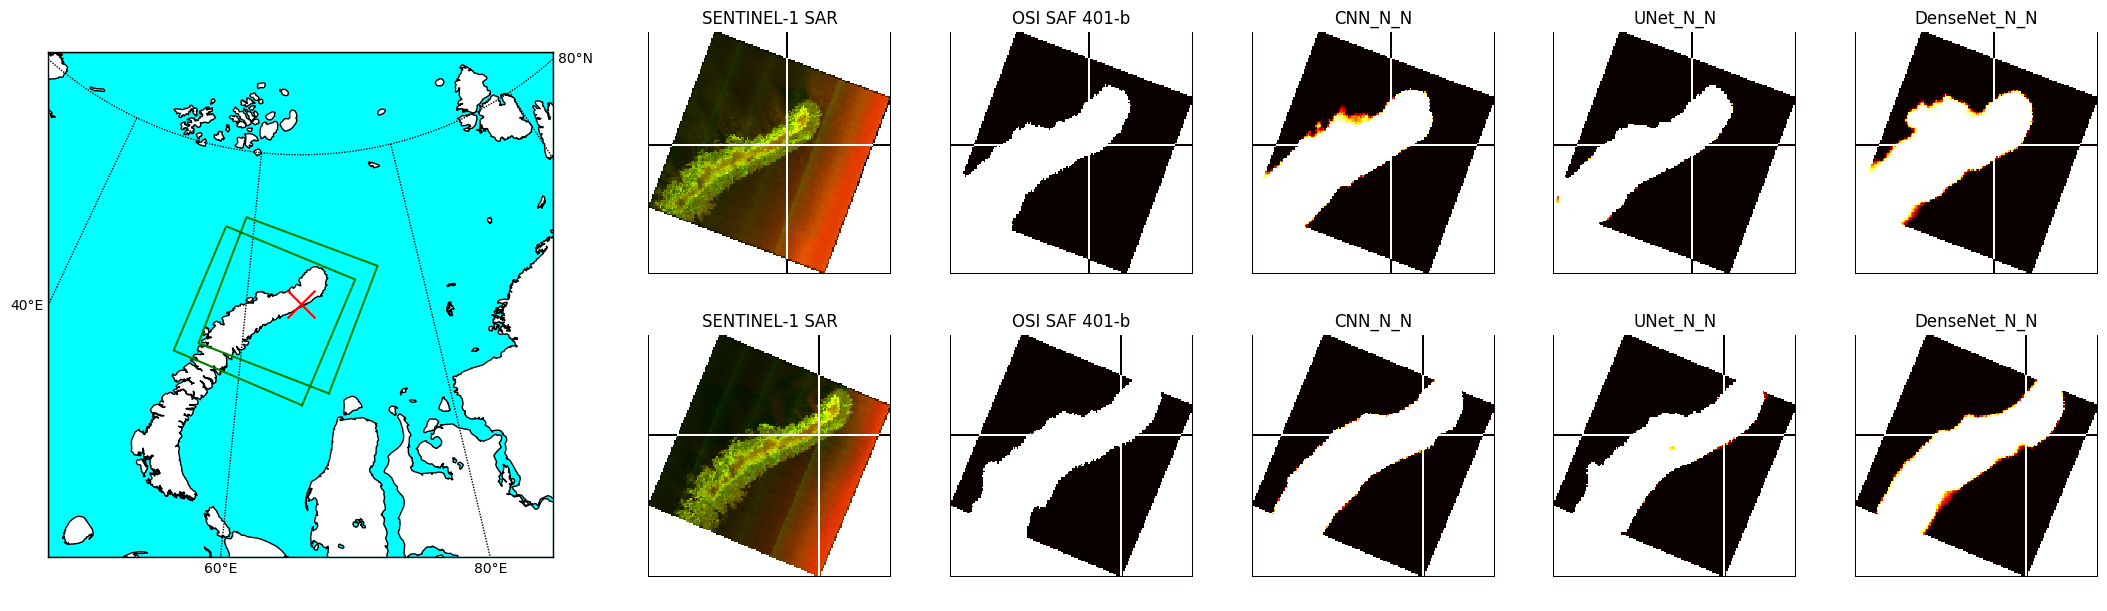

In [13]:
#@title #Search for SAR data by location and date

#@markdown ---
#@markdown ### Set location
user_lat = 76 #@param {type:"number"}
user_lon = 66 #@param {type:"number"}

#@markdown ---
#@markdown ### Set date range, or use today's date
start_date = "2019-10-08" #@param {type:"date"}
end_date = "2019-10-09" #@param {type:"date"}
use_current_date = False #@param {type:"boolean"}
#------------------------------------------------------------------------------#

# Set the start and end date based on the user's selections
if use_current_date:
  start_date = "NOW-1DAY"
  end_date = "NOW"
else:
  start_date = dt.date(year=int(start_date.split("-")[0]), month=int(start_date.split("-")[1]), day=int(start_date.split("-")[2]))
  end_date = dt.date(year=int(end_date.split("-")[0]), month=int(end_date.split("-")[1]), day=int(end_date.split("-")[2])) + dt.timedelta(days=1)

# Query SentinelSat for matching images
kwargs = {'platformname':'Sentinel-1',
          'producttype':'GRD',
          'sensoroperationalmode':'EW',
          'polarisationmode':'HH+HV'
         }

print("Searching for SENTINEL-1 images now...")
products = search_api.query(area="{}, {}".format(user_lat, user_lon),
                            date=(start_date, end_date),
                            area_relation="contains",
                            order_by="-beginposition",
                            **kwargs)

print("There are {} results matching the search criteria.".format(len(products)))

# Check if there are any results to show
if len(products) > 0:
  print("For more information, search uuid:\"<uuid>\" on Open Access Hub: https://scihub.copernicus.eu/dhus/#/home\n")
  
  # Make sure there is an empty temp directory to dump the images
  os.chdir("/home")
  if "Temp Image Folder" not in os.listdir(): os.mkdir("Temp Image Folder")
  os.chdir("Temp Image Folder")
  for f in os.listdir():
    os.remove(f)

  # Create the output figure, and grid layout (adjust size based on number of search results and number of models used for prediction)
  fig = plt.figure(constrained_layout=True, figsize=(3 * (len(selected_models) + 4), max(6, len(products) * 3)), dpi=100)
  widths = [2 if i == 0 else 1 for i in range(len(selected_models) + 3)]
  gs = fig.add_gridspec(ncols=len(selected_models) + 3,
                        nrows=len(products),
                        width_ratios=widths)

  # Add the Basemap chart, centered on the user's location
  map_plot = fig.add_subplot(gs[:min(2, len(products)), 0])
  projection = Basemap(width=1500000, height=1500000,
              resolution='i', projection='stere',
              lat_0=user_lat, lon_0=user_lon)
  projection.drawcoastlines()
  projection.fillcontinents(color='white', lake_color='aqua')
  projection.drawparallels(np.arange(-80.,81.,20.), labels=[False, True, True, False])
  projection.drawmeridians(np.arange(-180.,181.,20.), labels=[True, False, False, True])
  projection.drawmapboundary(fill_color='aqua')

  # Add the user's location as a point on the map
  projection.scatter(user_lon, user_lat, latlon=True, marker='x', c='r', s=400, alpha=1, zorder=3)

  # Iterate through all images returned by the query
  for uuid, info in products.items():
    print("UUID: {}, DATETIME: {}".format(uuid, info['beginposition']))

    # Request the image file from the HTTP server
    quicklook_url = os.path.join(service_root_URI, "Products('{}')/Products('Quicklook')/$value".format(uuid))
    response = requests.get(quicklook_url, auth=(odata_username, odata_password))

    # Check if the reponse was successful
    if (response.status_code == 200):
      # Save the file in the temp image folder
      open("{}.png".format(uuid), 'wb').write(response.content)

      # Read in the saved image, and resize it to the standard image dimmension
      image = cv2.resize(cv2.cvtColor(cv2.imread("{}.png".format(uuid)), cv2.COLOR_BGR2RGB), (image_dimension, image_dimension)) / 255

      # Determin if the image should be rotated based on pass direction
      if not correct_pass_direction(info):
        # print("Incorrect Pass Direction Attribute")
        image = cv2.flip(image, -1)
        if info['orbitdirection'] == "DESCENDING":
          # Since the pass direction is incorrect, this is actually ASCENDING
          image = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
      elif info['orbitdirection'] == "ASCENDING":
        # Since the pass direction is correct, this image can be treated as ASCENDING
        image = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)

      # Get the OSI SAF chart for this day, and generate the patch label
      nc_file, yesterday_flag = get_nc_file(info['beginposition'], user_lat)
      target = generate_label(image, info, nc_file)
      
      # Remove the blue channel
      image[:, :, 2] = np.zeros((image_dimension, image_dimension), dtype=np.uint8)
      
      # Get predictions from each model
      predictions = {}
      input_image = np.zeros((1, image_dimension, image_dimension, 2))
      input_image[0, :, :, :] = image[:, :, :2]
      for key, model in selected_models.items():
        predictions[key] = model.predict(input_image)[0, :, :, 0]
      
      # Get the distance mask for the specified location location
      distance_mask = getLocationMask(image, info, user_lat, user_lon)

      # Get the required rotation matrix
      matrix, shape = get_north_up_rotation_matrix(image, info, projection) # This needs to be improved

      # Create a mask to track the rotation of the image region, and apply the rotation to the distance mask
      # Ensure that the border values are set to 0, and not interpolated, since this can lead to incorrect distance values
      rotation_mask = cv2.warpAffine(np.ones((image_dimension, image_dimension)), matrix, shape, flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_CONSTANT, borderValue=0)
      distance_mask = cv2.warpAffine(distance_mask, matrix, shape, flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_CONSTANT, borderValue=0)

      # Apply the rotation to all images, ensuring that no interpolation happens, and filling the corners with white pixels
      image  = cv2.warpAffine(image, matrix, shape, flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_CONSTANT, borderValue=[1, 1, 1])
      target = cv2.warpAffine(target, matrix, shape, flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_CONSTANT, borderValue=1)
      for key in predictions:
        predictions[key] = cv2.warpAffine(predictions[key], matrix, shape, flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_CONSTANT, borderValue=1)

      # Apply crosshairs to images
      image  = apply_crosshairs(image, distance_mask, rotation_mask)
      target = apply_crosshairs(target, distance_mask, rotation_mask)
      for key in predictions:
        predictions[key] = apply_crosshairs(predictions[key], distance_mask, rotation_mask)

      # Project the footprint into the map coordinates
      plot_footprint(map_plot, projection, info)

      # Plot the SAR image, rotated and crosshaired
      fig.add_subplot(gs[list(products.keys()).index(uuid), 1])
      plt.imshow(image)
      plt.title("SENTINEL-1 SAR")
      plt.axis('off')

      # Plot the OSI SAF map, rotated and crosshaired
      fig.add_subplot(gs[list(products.keys()).index(uuid), 2])
      plt.imshow(target, cmap='hot', vmin=0, vmax=1)
      plt.title("OSI SAF 401-b{}".format(" (Yesterday)" if yesterday_flag else ""))
      plt.axis('off')

      # Plot each model's prediction for this image, rotated and crosshaired
      for i, key in enumerate(predictions.keys()):
        fig.add_subplot(gs[list(products.keys()).index(uuid), i + 3])
        plt.imshow(predictions[key], cmap='hot', vmin=0, vmax=1)
        plt.title(model_versions[key].split(" - ")[1])
        plt.axis('off')
        # plt.colorbar(shrink=0.6)
    else:
      # Tell the user that a file was not downloaded
      print("Download Failed - {}".format(uuid))
  plt.show()

# Compare OSI-401-b with in situ observations

Pangaea Dataset Filename: 2019-07-26_14.11.49_-56.6541_0.123720_054

OSI-401-b Reported Concentration: 0.00%


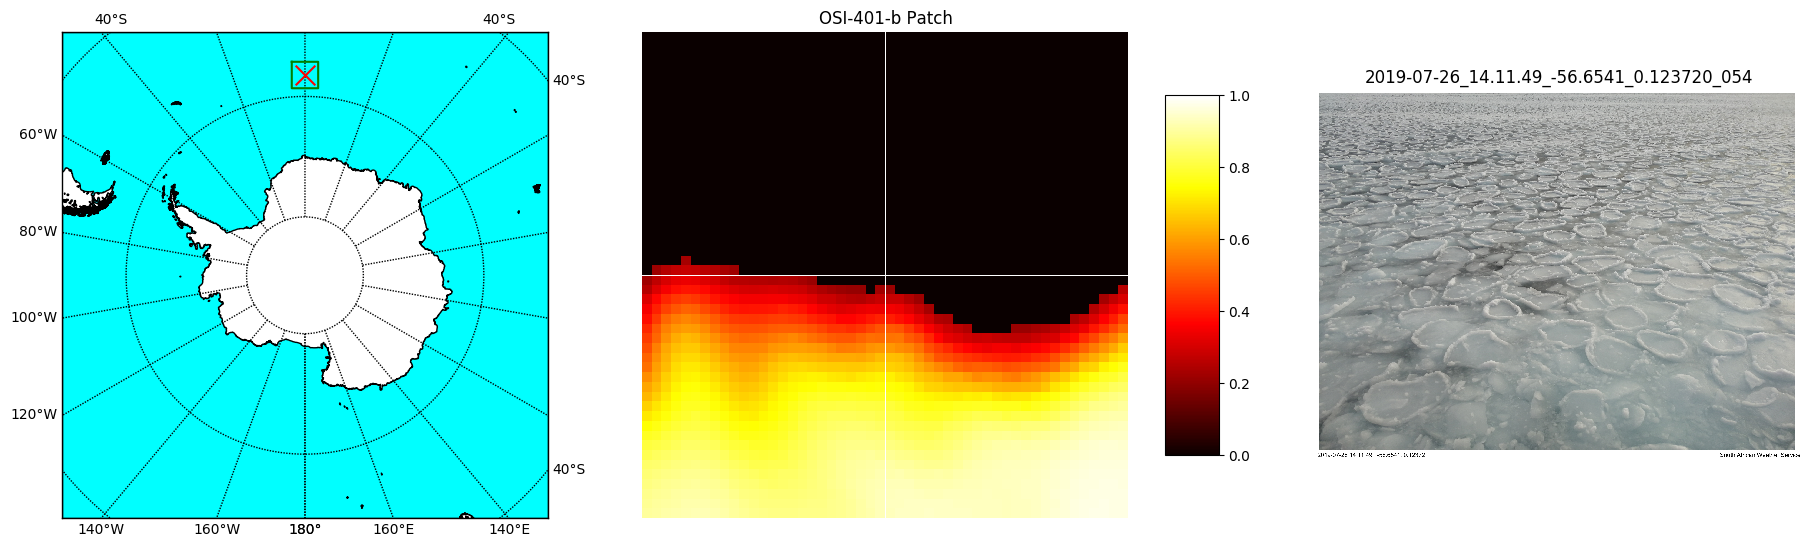

In [12]:
#@title # Evaluate OSI-401-b using Pangaea Dataset

#@markdown ---
#@markdown ### Use filename (leave blank otherwise)
pangaea_filename = "" #@param {type:"string"}

#@markdown ---
#@markdown ### Select from all images in date order
pangaea_filenumber = 68 #@param {type:"slider", min:0, max:232, step:1}
#------------------------------------------------------------------------------#

# function to download the selected iamge from the pangaea dataset
def get_pangaea_image(filename, url):
  os.chdir(os.path.join(dataset_location_path, "Pangaea_2019"))
  if "{}.png".format(filename) in os.listdir():
    # image has already been saved
    image = cv2.cvtColor(cv2.imread("{}.png".format(filename)), cv2.COLOR_BGR2RGB)
  else:
    # download the image
    response = requests.get(url)
    if response.status_code == 200:
      open("{}.png".format(filename), 'wb').write(response.content)
      image = cv2.cvtColor(cv2.imread("{}.png".format(filename)), cv2.COLOR_BGR2RGB)
    else:
      print("Bad response from server: {}".format(response.status_code))
      image = None
  return image

# function to get the concentration patch surrounding the location on interest
def get_concentration_patch(year, month, day, lat, lon):
  # Go to the pangaea folder
  os.chdir(os.path.join(dataset_location_path, "Pangaea_2019"))

  # File name for my use
  filename = "OSISAF_{0:04d}{1:02d}{2:02d}.nc"

  # Check if this file has already been downloaded
  if filename.format(year, month, day) not in os.listdir():
    # CMEMS Authentication Details
    cmems_username = "sdominicus"
    cmems_password = "zudvew-vIgtoh-3jigqi"

    # Product information
    server_name    = "nrt.cmems-du.eu"
    product_family = "SEAICE_GLO_SEAICE_L4_NRT_OBSERVATIONS_011_001"
    product_name   = "METNO-GLO-SEAICE_CONC-{}-L4-NRT-OBS".format("NORTH" if user_lat > 0 else "SOUTH")
    file_on_server = "{0:04d}/{1:02d}/ice_conc_{3}h_polstere-100_multi_{0:04d}{1:02d}{2:02d}1200.nc"

    # Connect to the CMEMS FTP server
    server = ftplib.FTP()
    server.connect(server_name)
    server.login(cmems_username, cmems_password)

    # Locate the desired product
    server.cwd("Core")
    server.cwd(product_family)
    server.cwd(product_name)

    # Save the file
    server.retrbinary("RETR " + file_on_server.format(year, month, day, "n" if user_lat > 0 else "s"), open(filename.format(year, month, day), 'wb').write)

    # Disconnect from the FTP server
    server.quit()
  
  # The file has been saved. Read it in
  nc_file = nc.Dataset(filename.format(year, month, day), 'r', format="NETCDF3")

  # Extract the relevent tables from the .nc file
  full_concentration = nc_file.variables['ice_conc'][0, :, :]
  # full_uncertainty   = nc_file.variables['total_uncertainty'][0, :, :]
  full_lat = np.array(nc_file.variables['lat'])
  full_lon = np.array(nc_file.variables['lon'])

  # Find the sample closest to the user's location
  distance_from_pixel = (full_lat - lat)**2 + (full_lon - lon)**2 # This is not Euclidian distance, but should be faster and still preserve order
  index = distance_from_pixel.argmin()
  y, x = index // distance_from_pixel.shape[1], index % distance_from_pixel.shape[1]

  # Get the value reported at the user's location
  value = full_concentration[y, x]

  # Slice the full arrays
  delta = 25
  reduced_concentration = full_concentration[y-delta:y+delta, x-delta:x+delta] / 100
  # reduced_uncertainty   = full_uncertainty[y-delta:y+delta, x-delta:x+delta] / 100
  reduced_lat = full_lat[y-delta:y+delta, x-delta:x+delta]
  reduced_lon = full_lon[y-delta:y+delta, x-delta:x+delta]

  footprint = [(reduced_lat[0,  0], reduced_lon[0,  0]),
               (reduced_lat[0, -1], reduced_lon[0, -1]),
               (reduced_lat[-1,-1], reduced_lon[-1,-1]),
               (reduced_lat[-1, 0], reduced_lon[-1, 0]),
               (reduced_lat[0,  0], reduced_lon[0,  0])]
  
  # Upsample the patch
  upscale_factor = 10
  reduced_concentration = cv2.resize(reduced_concentration, (delta * 2 * upscale_factor, delta * 2 * upscale_factor), interpolation=cv2.INTER_NEAREST)

  # Add cross hairs
  reduced_concentration[round(reduced_concentration.shape[0] / 2), :] = 1
  reduced_concentration[:, round(reduced_concentration.shape[1] / 2)] = 1

  return reduced_concentration, footprint, value

#------------------------------------------------------------------------------#
# Load the pangaea test file as a pandas dataframe
os.chdir(os.path.join(dataset_location_path, "Pangaea_2019"))
pangaea_df = pd.read_csv("dataset905497.tsv", sep="\t")

# Did the user enter a specific filename?
if pangaea_filename != "":
  # Does the filename exist in the dataset?
  if pangaea_filename in list(pangaea_df['File name']):
    # Yes - get the image
    pangaea_filenumber = pangaea_df[pangaea_df['File name'] == pangaea_filename].index[0]
    pangaea_image = pangaea_image = get_pangaea_image(pangaea_filename, pangaea_df['URL image'][pangaea_filenumber])
  else:
    # No - Cannot find file
    print("Filename not found.")
    pangaea_image = None
else:
  # No filename give, Use the slider values as the desired index
  pangaea_filename = pangaea_df['File name'][pangaea_filenumber]
  pangaea_image = get_pangaea_image(pangaea_filename, pangaea_df['URL image'][pangaea_filenumber])

if pangaea_image is None:
  # No image was returned
  print("There was a problem getting the image from the Pangaea dataset.")
else:
  print("Pangaea Dataset Filename: {}\n".format(pangaea_filename))

  # Get the date of the image
  date_time = pangaea_df['Date/Time'][pangaea_filenumber]
  date  = date_time.split("T")[0]
  time  = date_time.split("T")[1]
  year  = date.split("-")[0]
  month = date.split("-")[1]
  day   = date.split("-")[2]

  # Set the start and end date based on the image date
  delta_days = 3
  start_date = dt.date(year=int(year), month=int(month), day=int(day))
  end_date = start_date + dt.timedelta(days=delta_days)
  start_date -= dt.timedelta(days=delta_days)

  # Get the location of the image
  user_lat = pangaea_df['Latitude'][pangaea_filenumber]
  user_lon = pangaea_df['Longitude'][pangaea_filenumber]

  # Get the OSI chart and footprint
  concentration_chart, concentration_footprint, concentration_value = get_concentration_patch(int(year), int(month), int(day), user_lat, user_lon)
  print("OSI-401-b Reported Concentration: {:.2f}%".format(concentration_value))

  # Create the output figure, and grid layout
  fig = plt.figure(constrained_layout=True, figsize=(18, 6), dpi=100)
  widths = [1, 1, 1]
  gs = fig.add_gridspec(ncols=3,
                        nrows=1,
                        width_ratios=widths)

  # Add the Basemap chart, polar stereographic projection
  map_plot = fig.add_subplot(gs[0, 0])
  projection = Basemap(projection='npstere' if user_lat > 0 else 'spstere',
                       boundinglat=50 if user_lat > 0 else -50,
                       lon_0=180,
                       resolution='i')
  projection.drawcoastlines()
  projection.fillcontinents(color='white', lake_color='aqua')
  projection.drawparallels(np.arange(-80.,81.,20.), labels=[False, True, True, False])
  projection.drawmeridians(np.arange(-180.,181.,20.), labels=[True, False, False, True])
  projection.drawmapboundary(fill_color='aqua')

  # Add the user's location as a point on the map
  projection.scatter(user_lon, user_lat, latlon=True, marker='x', c='r', s=200, alpha=1, zorder=3)

  # Plot the chart footprint
  xy_vals = np.array([projection(concentration_footprint[i][1], concentration_footprint[i][0]) for i in range(5)])
  map_plot.plot(xy_vals[:, 0], xy_vals[:, 1], color='g')

  # Plot the concentration chart
  fig.add_subplot(gs[0, 1])
  plt.imshow(concentration_chart, cmap='hot', vmin=0, vmax=1)
  plt.title("OSI-401-b Patch")
  plt.axis('off')
  plt.colorbar(shrink=0.6)

  # Plot the Pangaea image
  fig.add_subplot(gs[0, 2])
  plt.imshow(pangaea_image)
  plt.title(pangaea_filename)
  plt.axis('off')

  plt.show()